In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


In [2]:
# Loading Data
df = pd.read_csv('COVID-19_Sentiments.csv')

In [3]:
df.head()

,Text_Id,Text,Date,Location,Sentiments
0,1241032866567356417,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:27 +0000 2020,"Uttar Pradesh, India",0.000
1,1241032867699765249,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:27 +0000 2020,Mumbai,0.000
2,1241032875102703616,"RT @SmokingSkills_: Daughter of an IAS, son of...",Fri Mar 20 16:04:29 +0000 2020,"Jodhpur, India",0.350
3,1241032877099237379,RT @narendramodi: The young actors have someth...,Fri Mar 20 16:04:29 +0000 2020,"Gurugram, Bharat",0.125
4,1241032870405128192,RT @theskindoctor13: Shaheen Bagh is still on....,Fri Mar 20 16:04:28 +0000 2020,"New Delhi, India",0.000


In [4]:
# Modifying Date
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [5]:
# Creating new_sentiments column out of polarities in sentiments
New_Sentiments_ls = []

for senti in df['Sentiments']:
    if senti < 0:
        New_Sentiments_ls.append(-1)
    elif senti > 0:
        New_Sentiments_ls.append(1)
    else:
        New_Sentiments_ls.append(0)

New_Sentiments_ls = pd.DataFrame(New_Sentiments_ls, columns=['New_Sentiments'])

df = pd.concat([df, New_Sentiments_ls], axis=1)

In [6]:
df.head()

,Text_Id,Text,Date,Location,Sentiments,New_Sentiments
0,1241032866567356417,RT @theskindoctor13: Shaheen Bagh is still on....,2020-03-20,"Uttar Pradesh, India",0.000,0
1,1241032867699765249,RT @theskindoctor13: Shaheen Bagh is still on....,2020-03-20,Mumbai,0.000,0
2,1241032875102703616,"RT @SmokingSkills_: Daughter of an IAS, son of...",2020-03-20,"Jodhpur, India",0.350,1
3,1241032877099237379,RT @narendramodi: The young actors have someth...,2020-03-20,"Gurugram, Bharat",0.125,1
4,1241032870405128192,RT @theskindoctor13: Shaheen Bagh is still on....,2020-03-20,"New Delhi, India",0.000,0


## Cleaning the text

In [7]:
# Cleaning the text
def func(x):
    try:
        trial = x.split(':')[1]
        return trial
    except:
        return x
df['Regenerated_Text'] = df['Text'].apply(lambda x: func(x))

In [8]:
# Converting to lower case
df['Regenerated_Text'] = df['Regenerated_Text'].apply(lambda x: x.lower())

# Removing urls
df['Regenerated_Text'] = df['Regenerated_Text'].apply(lambda x: x.split('https')[0])
df['Regenerated_Text'] = df['Regenerated_Text'].apply(lambda x: x.split('http')[0])

# Converting #word into just word
df['Regenerated_Text'] = df['Regenerated_Text'].str.replace('#', '')

# Remove @username
df['Regenerated_Text'] = df['Regenerated_Text'].str.replace('@[^\s]+','')

# Removing unwanted char
df['Regenerated_Text'] = df['Regenerated_Text'].str.replace("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ")    

# Remove additional white spaces
df['Regenerated_Text'] = df['Regenerated_Text'].str.replace('[\s]+', ' ')

In [9]:
df.head()

,Text_Id,Text,Date,Location,Sentiments,New_Sentiments,Regenerated_Text
0,1241032866567356417,RT @theskindoctor13: Shaheen Bagh is still on....,2020-03-20,"Uttar Pradesh, India",0.000,0,shaheen bagh is still on mosques are open mui...
1,1241032867699765249,RT @theskindoctor13: Shaheen Bagh is still on....,2020-03-20,Mumbai,0.000,0,shaheen bagh is still on mosques are open mui...
2,1241032875102703616,"RT @SmokingSkills_: Daughter of an IAS, son of...",2020-03-20,"Jodhpur, India",0.350,1,daughter of an ias son of a kolkata officer s...
3,1241032877099237379,RT @narendramodi: The young actors have someth...,2020-03-20,"Gurugram, Bharat",0.125,1,the young actors have something to say its ti...
4,1241032870405128192,RT @theskindoctor13: Shaheen Bagh is still on....,2020-03-20,"New Delhi, India",0.000,0,shaheen bagh is still on mosques are open mui...


In [10]:
df.shape

(648958, 7)

## Model Training

In [29]:
def acc_call(y_test, y_pred):
    
    # Calculating accuracy
    acc_score = round(accuracy_score(y_test, y_pred)*100, 2)
    f_one_score = round(f1_score(y_test, y_pred, average='weighted')*100, 2)
    acc_dict = {'Acc_Score': acc_score, 'F1_Score': f_one_score}
    
    return acc_dict

In [12]:
def con_mat_call(y_test, y_pred):
    
    # Creating confusion matrix
    unique_label = np.unique([y_test, y_pred])
    cmtx = pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels=unique_label), 
        index=['true:{:}'.format(x) for x in unique_label], 
        columns=['pred:{:}'.format(x) for x in unique_label]
    )
    
    return sns.heatmap(cmtx, cbar=False, annot=True, fmt='.2f')

In [40]:
def train_textblob(dataframe):
    '''This func uses textblob for finding sentiments and returns accuracy '''
    
    # feed in data to textblob
    sentiments = []
    for text in dataframe['Regenerated_Text']:
        analysis = TextBlob(text)

        if analysis.sentiment.polarity > 0:
            sentiments.append(1)
        elif analysis.sentiment.polarity < 0:
            sentiments.append(-1)
        else:
            sentiments.append(0)
    
    print(acc_call(dataframe['New_Sentiments'], sentiments))
    
    return con_mat_call(dataframe['New_Sentiments'], sentiments)

{'Acc_score': 85.88, 'F1_score': 85.93}
AxesSubplot(0.125,0.125;0.775x0.755)


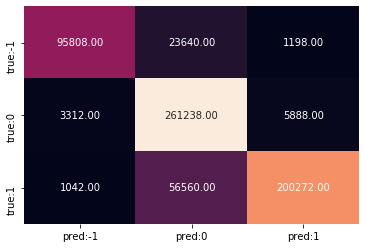

In [41]:
print(train_textblob(df))

# Step-2
    model training through nlp

In [13]:
# tokenization; process for creation of bag of words model.

corpus = []
for i in range(0, 648958):
    review = re.sub('[^a-zA-Z]', ' ', df['Regenerated_Text'][i])
    review = review.split()
    
    # The Porter stemming is used for removing the commoner
    # morphological and inflexional endings from words in English.
    ps = PorterStemmer()
    
    # Stopwords is a process of removing unnecessary english words
    # that are not took part in npl tasks.
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

In [14]:
len(corpus)

648958

In [15]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=99500)
X = cv.fit_transform(corpus)
y = df.New_Sentiments.values

In [16]:
print(f'X_shape-->{X.shape}')

X_shape-->(648958, 99500)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
print(f'X_train_shape-->{X_train.shape}; X_test_shape-->{X_test.shape}')

X_train_shape-->(454270, 99500); X_test_shape-->(194688, 99500)


In [51]:
def checking_models(X_train, X_test, y_train, y_test):
    '''This function is used to check accuracy on different models of nlp'''
    
    # Fitting and predicting logistic regression to the Training set.
    logreg_classifier = LogisticRegression()
    logreg_classifier.fit(X_train, y_train)
    y_pred_logreg_test = logreg_classifier.predict(X_test)
    y_pred_logreg_train = logreg_classifier.predict(X_train)
    
    # Fitting and predicting Naive Bayes to the Training set.
    nv_classifier = MultinomialNB()
    nv_classifier.fit(X_train, y_train)
    y_pred_nv_test = nv_classifier.predict(X_test)
    y_pred_nv_train = nv_classifier.predict(X_train)

    # Fitting and predicting Decision Tree to Training set.
    tree_classifier = DecisionTreeClassifier()
    tree_classifier.fit(X_train, y_train)
    y_pred_tree_test = tree_classifier.predict(X_test)
    y_pred_tree_train = tree_classifier.predict(X_train)
    
    # Fitting and predicting Random forest to Training set.
    ran_classifier = RandomForestClassifier()
    ran_classifier.fit(X_train, y_train)
    y_pred_ran_test = ran_classifier.predict(X_test)
    y_pred_ran_train = ran_classifier.predict(X_train)
    
    # Accuracy details.
    logreg_train_acc = acc_call(y_train, y_pred_logreg_train)
    logreg_test_acc = acc_call(y_test, y_pred_logreg_test)
    
    nv_train_acc = acc_call(y_train, y_pred_nv_train)
    nv_test_acc = acc_call(y_test, y_pred_nv_test)
    
    tree_train_acc = acc_call(y_train, y_pred_tree_train)
    tree_test_acc = acc_call(y_test, y_pred_tree_test)
    
    ran_train_acc = acc_call(y_train, y_pred_ran_train)
    ran_test_acc = acc_call(y_test, y_pred_ran_test)
    
    training_dict = {'Logistic Regression': logreg_train_acc,
                     'Naive Bayes': nv_train_acc,
                     'Decision Tree': tree_train_acc,
                     'Random Forest': ran_train_acc
                    }
    
    test_dict = {'Logistic Regression': logreg_test_acc,
                 'Naive Bayes': nv_test_acc,
                 'Decision Tree': tree_test_acc,
                 'Random Forest': ran_test_acc
                }
    
    print(f'Accuracy Checking for training data:- {training_dict}')
    print(f'Accuracy Checking for test data:- {test_dict}')
    
    # Returning dictionary of every prediction file for later use.
    pred_dict = {'Logistic_Regression_pred': [y_pred_logreg_train, y_pred_logreg_test],
                 'Naive_Bayes_pred': [y_pred_nv_train, y_pred_nv_test],
                 'Decision_Tree_pred': [y_pred_tree_train, y_pred_tree_test],
                 'Random_Forest_pred': [y_pred_ran_train, y_pred_ran_test]
                }
    
    return pred_dict

In [52]:
all_dict = checking_models(X_train, X_test, y_train, y_test)

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy Checking for training data:- {'Logistic Regression': {'Acc_Score': 91.38, 'F1_Score': 91.33}, 'Naive Bayes': {'Acc_Score': 83.08, 'F1_Score': 83.07}, 'Decision Tree': {'Acc_Score': 98.28, 'F1_Score': 98.28}, 'Random Forest': {'Acc_Score': 98.08, 'F1_Score': 98.08}}
Accuracy Checking for test data:- {'Logistic Regression': {'Acc_Score': 88.22, 'F1_Score': 88.1}, 'Naive Bayes': {'Acc_Score': 79.31, 'F1_Score': 79.19}, 'Decision Tree': {'Acc_Score': 97.71, 'F1_Score': 97.71}, 'Random Forest': {'Acc_Score': 97.25, 'F1_Score': 97.26}}


In [56]:
print(all_dict['Random_Forest_pred'])

[array([ 0,  0,  1, ..., -1,  0,  0], dtype=int64), array([0, 0, 1, ..., 1, 1, 0], dtype=int64)]


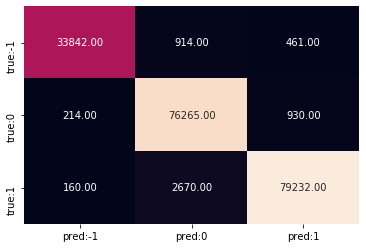

In [59]:
y_pred = all_dict['Random_Forest_pred'][1]
con_mat_call(y_test, y_pred)

In [64]:
sentiments_NLP = np.concatenate((all_dict['Random_Forest_pred'][0], y_pred))
sentiments_NLP

array([0, 0, 1, ..., 1, 1, 0], dtype=int64)

In [67]:
Date_Sentiments = pd.DataFrame({
                                'Date': df['Date'],
                                'Sentiments': sentiments_NLP,
                               })

In [68]:
Date_Sentiments.head()

,Date,Sentiments
0,2020-03-20,0
1,2020-03-20,0
2,2020-03-20,1
3,2020-03-20,1
4,2020-03-20,0


In [69]:
Date_Sentiments.to_csv('Date_Sentiments.csv', index=False)